In [36]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2

def plot_individual_plant(ax, dataframe, name="Example"):
    dataframe.plot(x = 'ElapsedTime (h)', y = 'MainRootLength (mm)', ax = ax, color = 'g')
    dataframe.plot(x = 'ElapsedTime (h)', y = 'LateralRootsLength (mm)', ax = ax, color = 'b')
    ax.set_title('%s' % name, pad=20)
    ax.set_ylabel('Length (mm)')

    # increase font sizes 
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.title.set_size(18)
    ax.legend(fontsize = 18)

    # Create a second x-axis for displaying the hours
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    # Calculate the total number of days
    total_days = np.ceil(dataframe['ElapsedTime (h)'].max() / 24).astype(int)

    # Create day ticks
    day_ticks = np.arange(24, total_days * 24 + 1, 24)

    # Set day ticks and labels
    ax2.set_xticks(day_ticks)
    ax2.set_xticklabels([f'Day {i}' for i in range(1, total_days+1)], rotation=45)

    # Customize the appearance of the ticks and tick labels
    ax2.tick_params(axis='x', which='major', length=8, width=2, color='black')
    ax2.tick_params(axis='x', which='minor', length=4, width=1, color='black')
    ax2.tick_params(axis='x', which='major', labelsize=12)
    
    # Change legends to MR Length and LR Length
    ax.legend(['Main Root Length', 'Sum of Lateral Roots Lengths'], fontsize = 18)
    ax.set_xlabel('Time (h)', fontsize = 18)
    ax.set_ylabel('Length (mm)', fontsize = 18)
    


def plot_individual_plant_lr(ax, dataframe):
    # preprocess dataframe Number of Lateral Roots to be increasing

    #for i in range(1, len(dataframe)):
    #    if dataframe['NumberOfLateralRoots'][i] < dataframe['NumberOfLateralRoots'][i-1]:
    #        dataframe['NumberOfLateralRoots'][i] = dataframe['NumberOfLateralRoots'][i-1]

    dataframe.plot(x = 'ElapsedTime (h)', y = 'NumberOfLateralRoots', ax = ax, color = 'g')
    ax.set_ylabel('Length (mm)')

    # increase font sizes 
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.title.set_size(18)
    ax.legend(fontsize = 18)

    # Create a second x-axis for displaying the hours
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    # Calculate the total number of days
    total_days = np.ceil(dataframe['ElapsedTime (h)'].max() / 24).astype(int)

    # Create day ticks
    day_ticks = np.arange(24, total_days * 24 + 1, 24)

    # Set day ticks and labels
    ax2.set_xticks(day_ticks)
    ax2.set_xticklabels([f'Day {i}' for i in range(1, total_days+1)], rotation=45)

    # Customize the appearance of the ticks and tick labels
    ax2.tick_params(axis='x', which='major', length=8, width=2, color='black')
    ax2.tick_params(axis='x', which='minor', length=4, width=1, color='black')
    ax2.tick_params(axis='x', which='major', labelsize=12)
    
    # Change legends to MR Length and LR Length
    ax.legend(['Number of lateral roots'], fontsize = 18)
    ax.set_xlabel('Time (h)', fontsize = 18)
    ax.set_ylabel('Amount', fontsize = 18)
    
def plot_graph(g, shape):
    pos = g.vp.pos
    nodetype = g.vp.nodetype
    clase = g.ep.clase
    
    aux = np.zeros(shape, dtype='uint8')
    
    for pair in g.get_edges():
        v1 = pair[0]
        p1 = tuple(np.array(pos[v1], dtype='int64'))
        v2 = pair[1]
        p2 = tuple(np.array(pos[v2], dtype='int64'))
        
        edge = g.edge(v1,v2)
        if clase[edge][1] == 10:
            cv2.line(aux, p1, p2, (0, 255, 0), 3)
        else:
            cv2.line(aux, p1, p2, (0, 0, 255), 3)
            
    for i in g.get_vertices():
        p = tuple(np.array(pos[i], dtype='int64'))
        if nodetype[i] == 'Ini' or nodetype[i] == 'FTip':
            cv2.circle(aux, p, 7, (0, 255, 0), -1)
        elif nodetype[i] == 'LTip':
            cv2.circle(aux, p, 7, (255, 255, 0), -1)
        else:
            cv2.circle(aux, p, 7, (0, 255, 255), -1)
        
    return aux



In [37]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import cv2
from analysis.utils.fileUtilities import loadPath
import csv

def recorrerRaiz(raiz, LR = False):
    if LR:
        raiz = raiz[0]

    p = []
    for punto in raiz[0]:
        x = int(punto.attrib['x'])
        y = int(punto.attrib['y'])
        p.append([x,y])
  
    ini = p[0]
    fin = p[-1]

    if ini[1] > fin[1]:
        return p[::-1]
    else:
        return p

def tipAngle(puntos):
    ini = puntos[0]
    fin = puntos[-1]
    hipot = np.sqrt((ini[0]-fin[0])**2 + (ini[1]-fin[1])**2)
    cat = fin[1]-ini[1]

    angle_rad = np.arccos(cat/hipot)
    angle_deg = angle_rad*180/np.pi

    return angle_deg

def emergenceAngle(puntos, largo = 1, pixelsize = 0.04):            
    l = int(largo/pixelsize)
    N = len(puntos)
    ini = puntos[0]
    fin = puntos[min(l, N)-1]

    hipot = np.sqrt((ini[0]-fin[0])**2 + (ini[1]-fin[1])**2)
    cat = fin[1]-ini[1]

    angle_rad = np.arccos(cat/hipot)
    angle_deg = angle_rad*180/np.pi

    return angle_deg


def plotAngles(ax, puntos, angle, tip = True, largo = 2, pixelsize = 0.04):
    if tip:
        ini = puntos[0]
        fin = puntos[-1]
    else:
        l = int(largo/pixelsize)
        N = len(puntos)

        ini = puntos[0]
        fin = puntos[min(l, N)-1]

    xs = ini[0], fin[0]
    ys = ini[1], fin[1]
    ax.plot(xs, ys, linewidth = 1)

    xs = ini[0], fin[0]
    ys = ini[1], fin[1]
    ax.plot([ini[0], ini[0]], ys, linewidth = 1)

    ax.text(x = ini[0] + 10, y = ini[1], s = str(round(angle,2)) + "°", fontsize = 8)

    return

def find_nearest(point, listpoints):
    d = np.linalg.norm(point-listpoints, axis = 1)
    p = np.argmin(d)

    return p, d[p]

def matching(newInis, allNewPoints, oldInis, allOldPoints, oldNames, NRoots = 0):
    # newInis : begin of lateral roots - this run
    # allNewPoints : all points of the lateral root polyline - this run
    
    # oldInis : begin of lateral roots
    # allOldPoints : all points of the lateral root polyline
    # oldNames : names in previous iteration

    matchedNames = []
    matchedInis = []
    matchedPoints = []

    seen = []

    if oldInis == [] or oldNames == []:
        for j in range(0,len(newInis)):
            matchedNames.append('LR%s'%NRoots)
            matchedInis.append(newInis[j])
            matchedPoints.append(allNewPoints[j])
            NRoots += 1
    else:
        op = np.array(oldInis)
        nps = np.array(newInis)

        for j in range(0, nps.shape[0]):
            p, dp = find_nearest(nps[j,:], op)

            if dp < 20:
                matchedNames.append(oldNames[p])
                matchedInis.append(newInis[j])
                matchedPoints.append(allNewPoints[j])
                seen.append(p)
            else:
                matchedNames.append('LR%s'%NRoots)
                matchedInis.append(newInis[j])
                matchedPoints.append(allNewPoints[j])
                NRoots += 1
        
        N_old = op.shape[0]
        seen.sort()

        for j in range(0, N_old):
            if j not in seen:
                matchedNames.append(oldNames[j])
                matchedInis.append(oldInis[j])
                matchedPoints.append(allOldPoints[j])

        idxs = np.argsort(np.array(matchedNames))
        matchedNames = np.array(matchedNames,dtype=object)[idxs].tolist()
        matchedInis = np.array(matchedInis,dtype=object)[idxs].tolist()
        matchedPoints = np.array(matchedPoints,dtype=object)[idxs].tolist()   

    return matchedInis, matchedPoints, matchedNames, NRoots

def lenRoot(points, pixel_size = 0.04):
    accum = 0
    for j in range(1, len(points)):
        d = np.linalg.norm(np.array(points[j]) - np.array(points[j-1]))
        accum += (d * pixel_size)
    
    return accum

def estimateAngles(path, ax, img, i = -1, tip=False):
    plt.ioff()
    paths = loadPath(os.path.join(path,'RSML'))

    LateralRoots = []
    LateralRootsInis = []
    LateralRootsNames = []
    NRoots = 0


    step = paths[i]
    arbol = ET.parse(step).getroot()

    with open(os.path.join(path, 'metadata.json')) as f:
        metadata = json.load(f)

    y1,y2,x1,x2 = metadata['bounding box']
    h = y2-y1
    w = x2-x1

    plant = arbol[1][0][0]
    
    if len(plant) > 1:
        LRs = plant[1:]
        
        pts = []
        inis = []

        ## Primero hago el tracking
        for LR in LRs:
            puntos = recorrerRaiz(LR, True)
            pts.append(puntos)
            inis.append(puntos[0])

        LateralRootsInis, LateralRoots, LateralRootsNames, NRoots = matching(inis, pts, LateralRootsInis, LateralRoots, LateralRootsNames, NRoots)
        
        ## Luego estimo los angulos
        tips = []
        emergs = []
        lengths = []

        for root in LateralRoots:
            TipAngle = tipAngle(root)
            EmergenceAngle = emergenceAngle(root, 2, metadata['pixel_size'])

            tips.append(TipAngle)
            emergs.append(EmergenceAngle)

        ax.imshow(img)
        
        for i in range(0, len(pts)):            
            if not tip:
                plotAngles(ax, pts[i], emergs[i], tip = tip)
            else:
                plotAngles(ax, pts[i], tips[i], tip = tip)
        ax.axis('off')
    
    return ax

In [38]:
""" 
ChronoRoot: High-throughput phenotyping by deep learning reveals novel temporal parameters of plant root system architecture
Copyright (C) 2020 Nicolás Gaggion

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import re
import pandas as pd
import os
from scipy import signal
import json

def dataWork(pfile, metadata, N_exp = None):
    data = pd.read_csv(pfile)
    shape = data.shape
    N = shape[0]

    # Read info from the filename

    dates = []
    for i in range(0,N):
        name = data['FileName'][i]
        nums = re.findall(r'\d+', name)
        date = nums[0] + '-' + nums[1] + '-' + nums[2] + '-' + nums[3] + ':' + nums[4] 
        dates.append(date)

    data.insert(data.shape[1], 'Date', dates)
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d-%H:%M')

    # Checks for missing values

    timeStep = metadata['timeStep']
    timeStep = pd.Timedelta(minutes=timeStep)
    first = data['Date'][0]
    last = data['Date'][N-1]
    dates = pd.date_range(first, last, freq=timeStep)

    for date in dates:
        if not data['Date'].isin([date]).any():        
            data = pd.concat([data, pd.DataFrame({'Date': [date]})], ignore_index=True)
            #print('Missing date: ' + str(date))

    data = data.sort_values(by=['Date'])
    data = data.reset_index(drop=True)
    data = data.fillna(method='ffill')
    
    N = data.shape[0]

    # Trims or expands the data to the desired number of measurements
    
    if N_exp is not None:
        if N > N_exp:
            data = data.iloc[0:N_exp]
        else:
            # add rows with last data
            for i in range(N,N_exp):
                data = pd.concat([data, data.iloc[N-1]], ignore_index=True)

    # If there is a repeated date, it is updated by a time step

    shape = data.shape
    N = shape[0]

    for i in range(1,N):
        if data['Date'][i] == data['Date'][i-1]:
            data.loc[i, 'Date'] = data['Date'][i] + timeStep
        if data['Date'][i] < data['Date'][i-1]:
            data.loc[i, 'Date'] = data['Date'][i-1] + timeStep
    
    # Reads the pixel size

    pixel_size = metadata['pixel_size']
    
    # Beggining of the data processing

    index = data['Frame'].to_numpy()
    mainRoot = data['MainRootLength'].to_numpy().astype('float')
    lateralRoots = data['LateralRootsLength'].to_numpy().astype('float')
    numlateralRoots = data['NumberOfLateralRoots'].to_numpy().astype('float')

    # Used to remove spurious values at the beggining
    space = 32
    for t in range(space, N//2):
        if numlateralRoots[t-space] == 0 and numlateralRoots[t] == 0:
            lateralRoots[t-space:t] = 0
            numlateralRoots[t-space:t] = 0

    # Smooth
    mainRoot = signal.medfilt(mainRoot, 9) 
    lateralRoots = signal.medfilt(lateralRoots, 9) 
    numlateralRoots = signal.medfilt(numlateralRoots, 9)

    # Check that the values never decreases
    for i in range(1, len(mainRoot)):
        dif = mainRoot[i] < mainRoot[i-1]
        if dif:
            mainRoot[i] = mainRoot[i-1]
        
        dif = numlateralRoots[i] < numlateralRoots[i-1]
        if dif:
            numlateralRoots[i] = numlateralRoots[i-1]

        dif = lateralRoots[i] < lateralRoots[i-1]
        if dif and lateralRoots[i-1] > 10:
            lateralRoots[i] = lateralRoots[i-1]

    # Multiply by pixel size
    mainRoot_mm = mainRoot.copy() * pixel_size
    lateralRoots_mm = lateralRoots.copy() * pixel_size
    
    data['MainRootLength (mm)'] = mainRoot_mm
    data['LateralRootsLength (mm)'] = lateralRoots_mm
    data['NumberOfLateralRoots'] = numlateralRoots
    data['TotalLength (mm)'] = mainRoot_mm + lateralRoots_mm

    # Removes original columns
    data = data.drop(columns=['FileName', 'Frame', 'MainRootLength', 'LateralRootsLength', 'TotalLength'])
    # Reorders columns
    data = data[['Date', 'MainRootLength (mm)', 'LateralRootsLength (mm)', 'TotalLength (mm)', 'NumberOfLateralRoots']]
    # creates an elapsed time column, in hours
    data['ElapsedTime (h)'] = ((data['Date'] - data['Date'][0]).dt.total_seconds() / 3600).round(2)
    # Creates a column that is True if the hour is 00:00, checking hours and minutes
    data['NewDay'] = (data['Date'].dt.hour == 0) & (data['Date'].dt.minute == 0)

    # Downsamples the data to a 60 minutes timestep
    data = data.set_index('Date')
    data = data.resample('60T').mean()
    data = data.reset_index()

    # Creates a column that is True if the hour is 00:00, checking hours and minutes
    data['NewDay'] = (data['Date'].dt.hour == 0) & (data['Date'].dt.minute == 0)
    # Re estimates the elapsed time
    data['ElapsedTime (h)'] = ((data['Date'] - data['Date'][0]).dt.total_seconds() / 3600).round(0)
    # Rounds the number of lateral roots
    data['NumberOfLateralRoots'] = data['NumberOfLateralRoots'].round(0)

    # Calculates gradients for the root lengths
    mainRootGrad = np.gradient(data['MainRootLength (mm)'].to_numpy(), edge_order = 2)
    lateralRootsGrad = np.gradient(data['LateralRootsLength (mm)'].to_numpy(), edge_order = 2)
    totalRootsGrad = np.gradient(data['TotalLength (mm)'].to_numpy(), edge_order = 2)
    
    # Main over total
    mainOverTotal = data['MainRootLength (mm)'].to_numpy() / data['TotalLength (mm)'].to_numpy() * 100
    where_nans = np.isnan(mainOverTotal)
    mainOverTotal[where_nans] = 100.0
    mainOverTotal = signal.medfilt(mainOverTotal, 5)

    # Lateral density
    lateralDensity = data['LateralRootsLength (mm)'].to_numpy() / data['MainRootLength (mm)'].to_numpy()
    where_nans = np.isnan(lateralDensity)
    lateralDensity[where_nans] = 0.0
    lateralDensity = signal.medfilt(lateralDensity, 5)

    # Discrete lateral density
    discreteLateralDensity = 10 * data['NumberOfLateralRoots'].to_numpy() / data['MainRootLength (mm)'].to_numpy()
    where_nans = np.isnan(discreteLateralDensity)
    discreteLateralDensity[where_nans] = 0.0
    discreteLateralDensity = signal.medfilt(discreteLateralDensity, 5)

    # Adds the new columns
    data['MainRootLengthGrad (mm/h)'] = mainRootGrad
    data['LateralRootsLengthGrad (mm/h)'] = lateralRootsGrad
    data['TotalLengthGrad (mm/h)'] = totalRootsGrad
    data['MainOverTotal (%)'] = mainOverTotal
    data['LateralDensity (mm/mm)'] = lateralDensity
    data['DiscreteLateralDensity (LR/cm)'] = discreteLateralDensity

    
    return data    
 


In [39]:
import pandas as pd 
import json 
import os 
import cv2
import graph_tool.all as gt


path = "/home/ngaggion/DATA/Raices/Analisis/NFYA10_COMB/NFYA10/rpi23_o/cam_1/plant_1/Results_0"
path = "/home/ngaggion/DATA/Raices/Analisis/NFYA10_COMB/Analysis/WT/rpi11_o/cam_4/plant_1/Results_0"
csv_path = path + "/Results_raw.csv"

metadata_path = path + "/metadata.json"
metadata = json.load(open(metadata_path))

df = dataWork(csv_path, metadata)



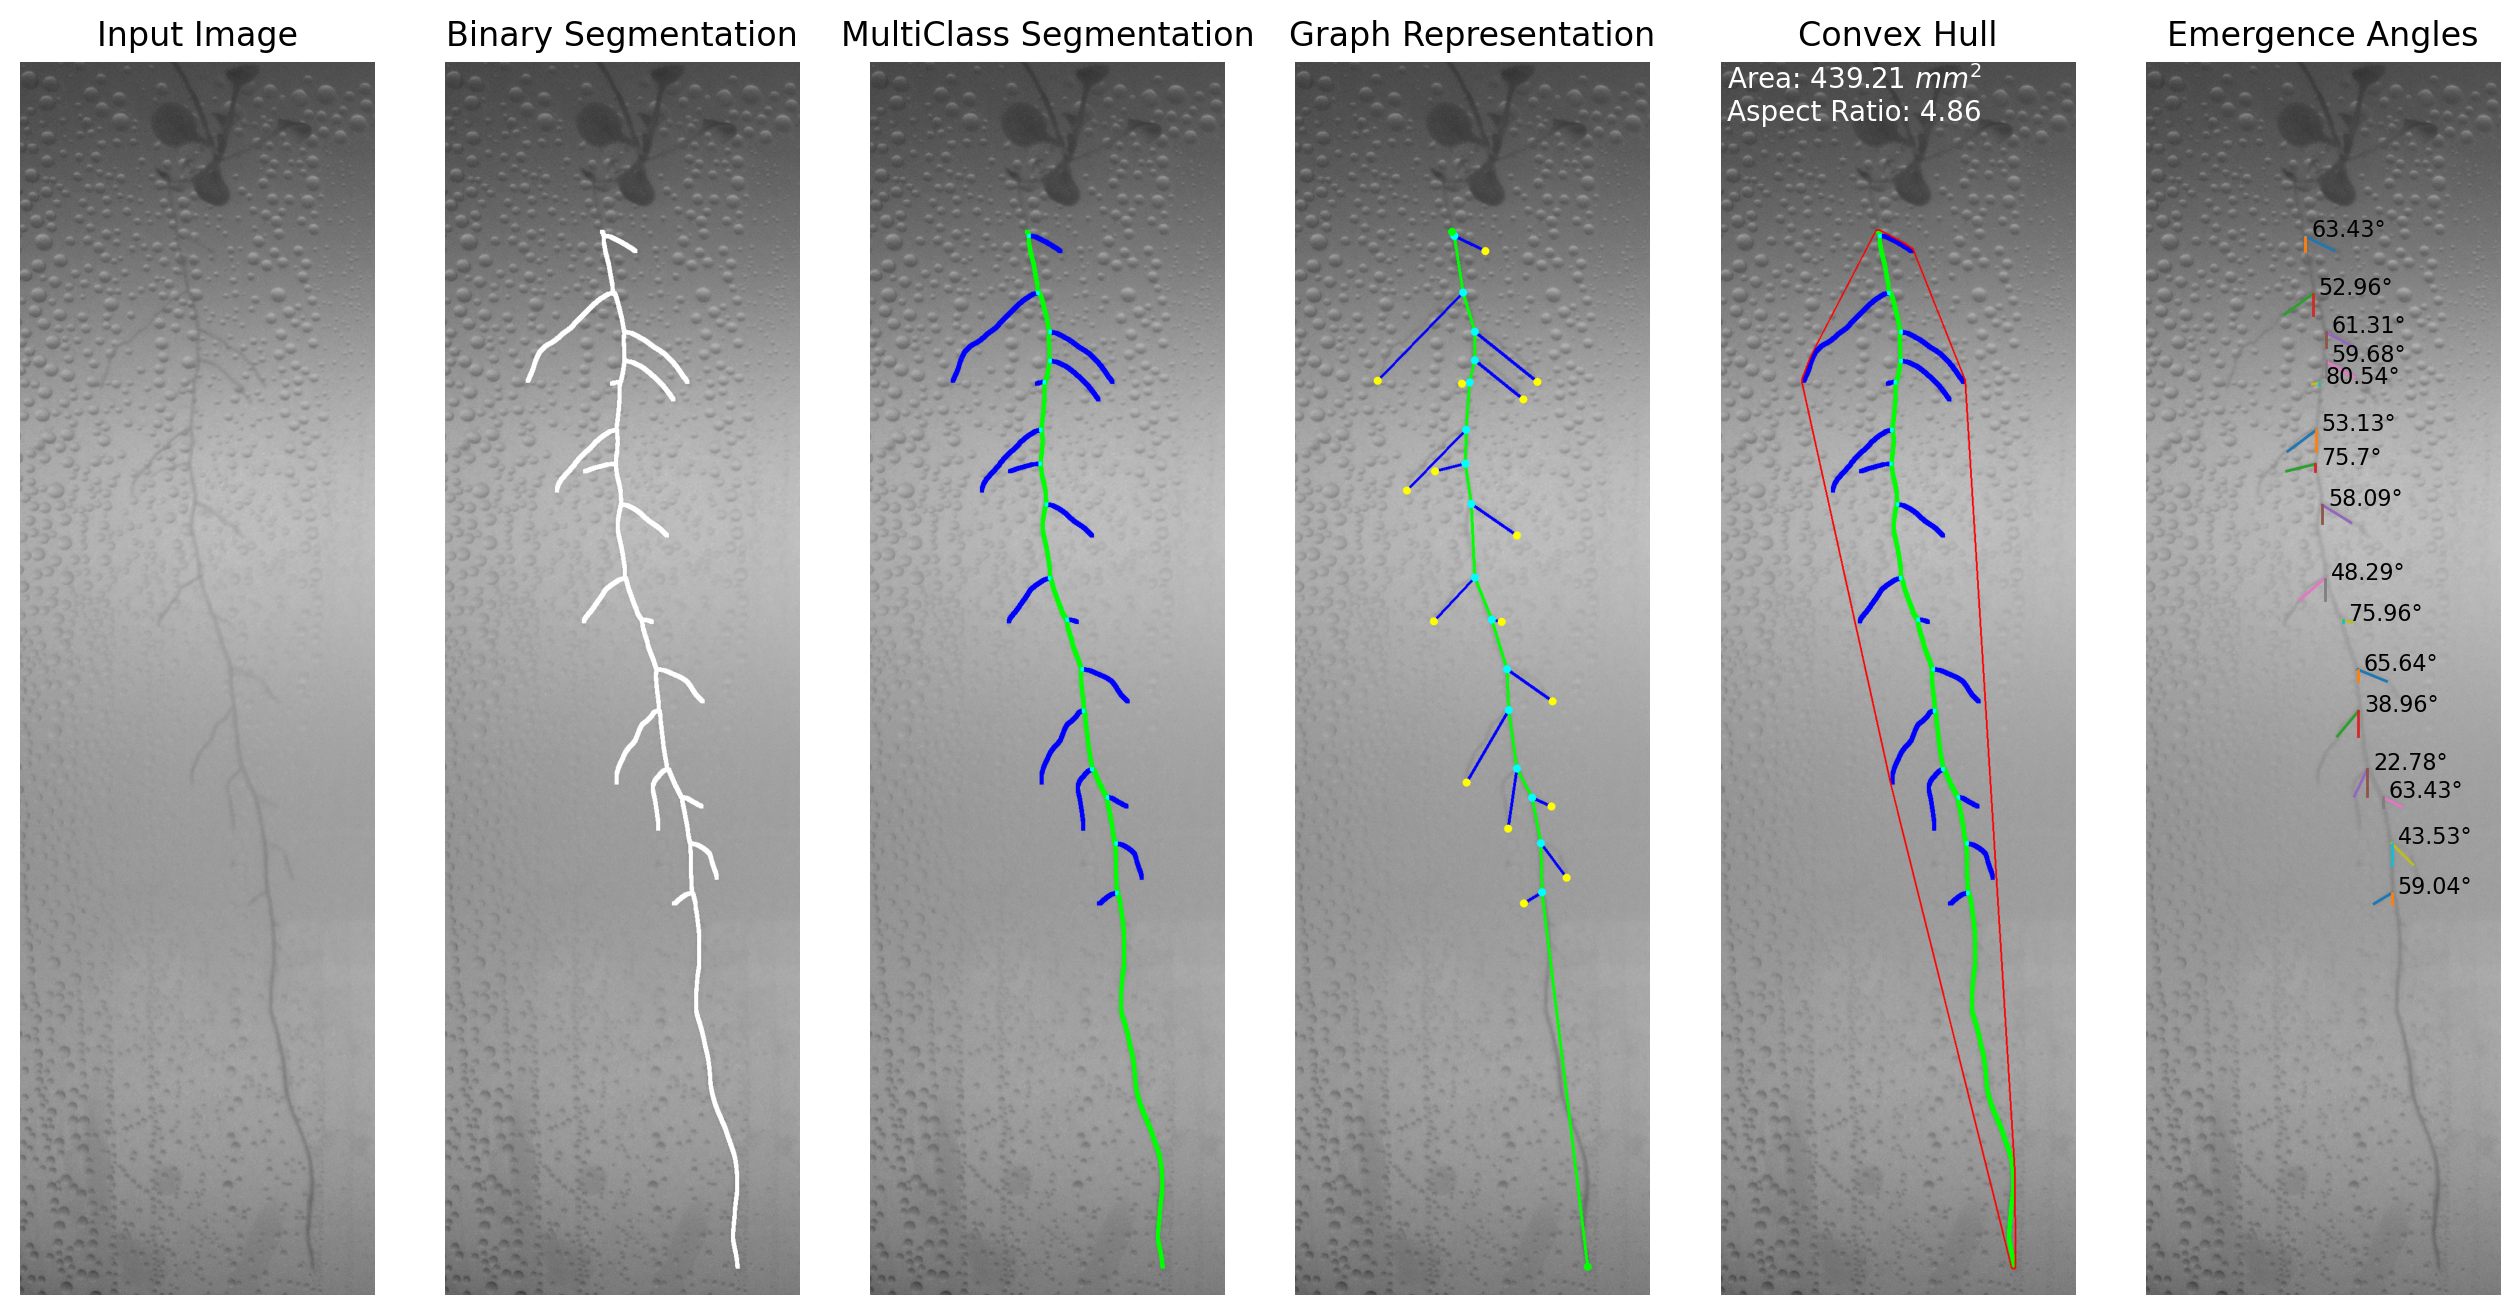

In [40]:
image_path = os.listdir(metadata["ImagePath"])
i = -1

images = sorted([os.path.join(metadata["ImagePath"], image) for image in image_path if image.endswith(".png")])
segmentation = path + "/Images/SegMulti/" + os.path.basename(images[i])

bbox = metadata["bounding box"]
crop = cv2.imread(images[i])[bbox[0]:bbox[1], bbox[2]:bbox[3]]

seg = cv2.cvtColor(cv2.imread(segmentation), cv2.COLOR_RGB2BGR)
binary_seg = (seg.sum(axis=2) > 0).astype("uint8")

overlay_binary = crop.copy()
overlay_binary[binary_seg == 1, :] = 255

overlay = crop.copy()
overlay[binary_seg == 1, :] = 0
overlay[seg == 255] = 255

contours, hierarchy = cv2.findContours(binary_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
convex_hull = [cv2.convexHull(contour) for contour in contours]

overlay_contours = cv2.drawContours(overlay.copy(), convex_hull, -1, (255, 0, 0), 2)

# load from file
path_grafo = path + "/Graphs/" + os.path.basename(images[i]).replace(".png", ".xml.gz")
g = gt.load_graph(path_grafo)

grafo = plot_graph(g, crop.shape).astype("uint8")
binary_graph = (grafo.sum(axis=2) > 0).astype("uint8")
overlay_grafo = crop.copy()
overlay_grafo[binary_graph == 1, :] = 0
overlay_grafo[grafo == 255] = 255

plt.figure(figsize = (16, 48), dpi = 200)

plt.subplot(1,6,1)
plt.imshow(crop, cmap = "gray")
plt.axis("off")
plt.title("Input Image")

plt.subplot(1,6,2)
plt.imshow(overlay_binary)
plt.axis("off")
plt.title("Binary Segmentation")

plt.subplot(1,6,3)
plt.imshow(overlay)
plt.axis("off")
plt.title("MultiClass Segmentation")

plt.subplot(1,6,4)
plt.imshow(overlay_grafo)
plt.axis("off")
plt.title("Graph Representation")

plt.subplot(1,6,5)
plt.imshow(overlay_contours)
plt.axis("off")
plt.title("Convex Hull")

x,y,w,h = cv2.boundingRect(convex_hull[0])
area_chull = cv2.contourArea(convex_hull[0]) * 0.04 * 0.04
aspect_ratio = h/w
plt.text(10, 100, f"Area: {area_chull:.2f} $mm^2$ \nAspect Ratio: {aspect_ratio:.2f}", fontsize = 10, color = "white")

ax = plt.subplot(1,6,6)
estimateAngles(path, ax, crop.copy(), i)
plt.title("Emergence Angles")

plt.savefig("example/test.png", bbox_inches = "tight", dpi = 200)

plt.show()


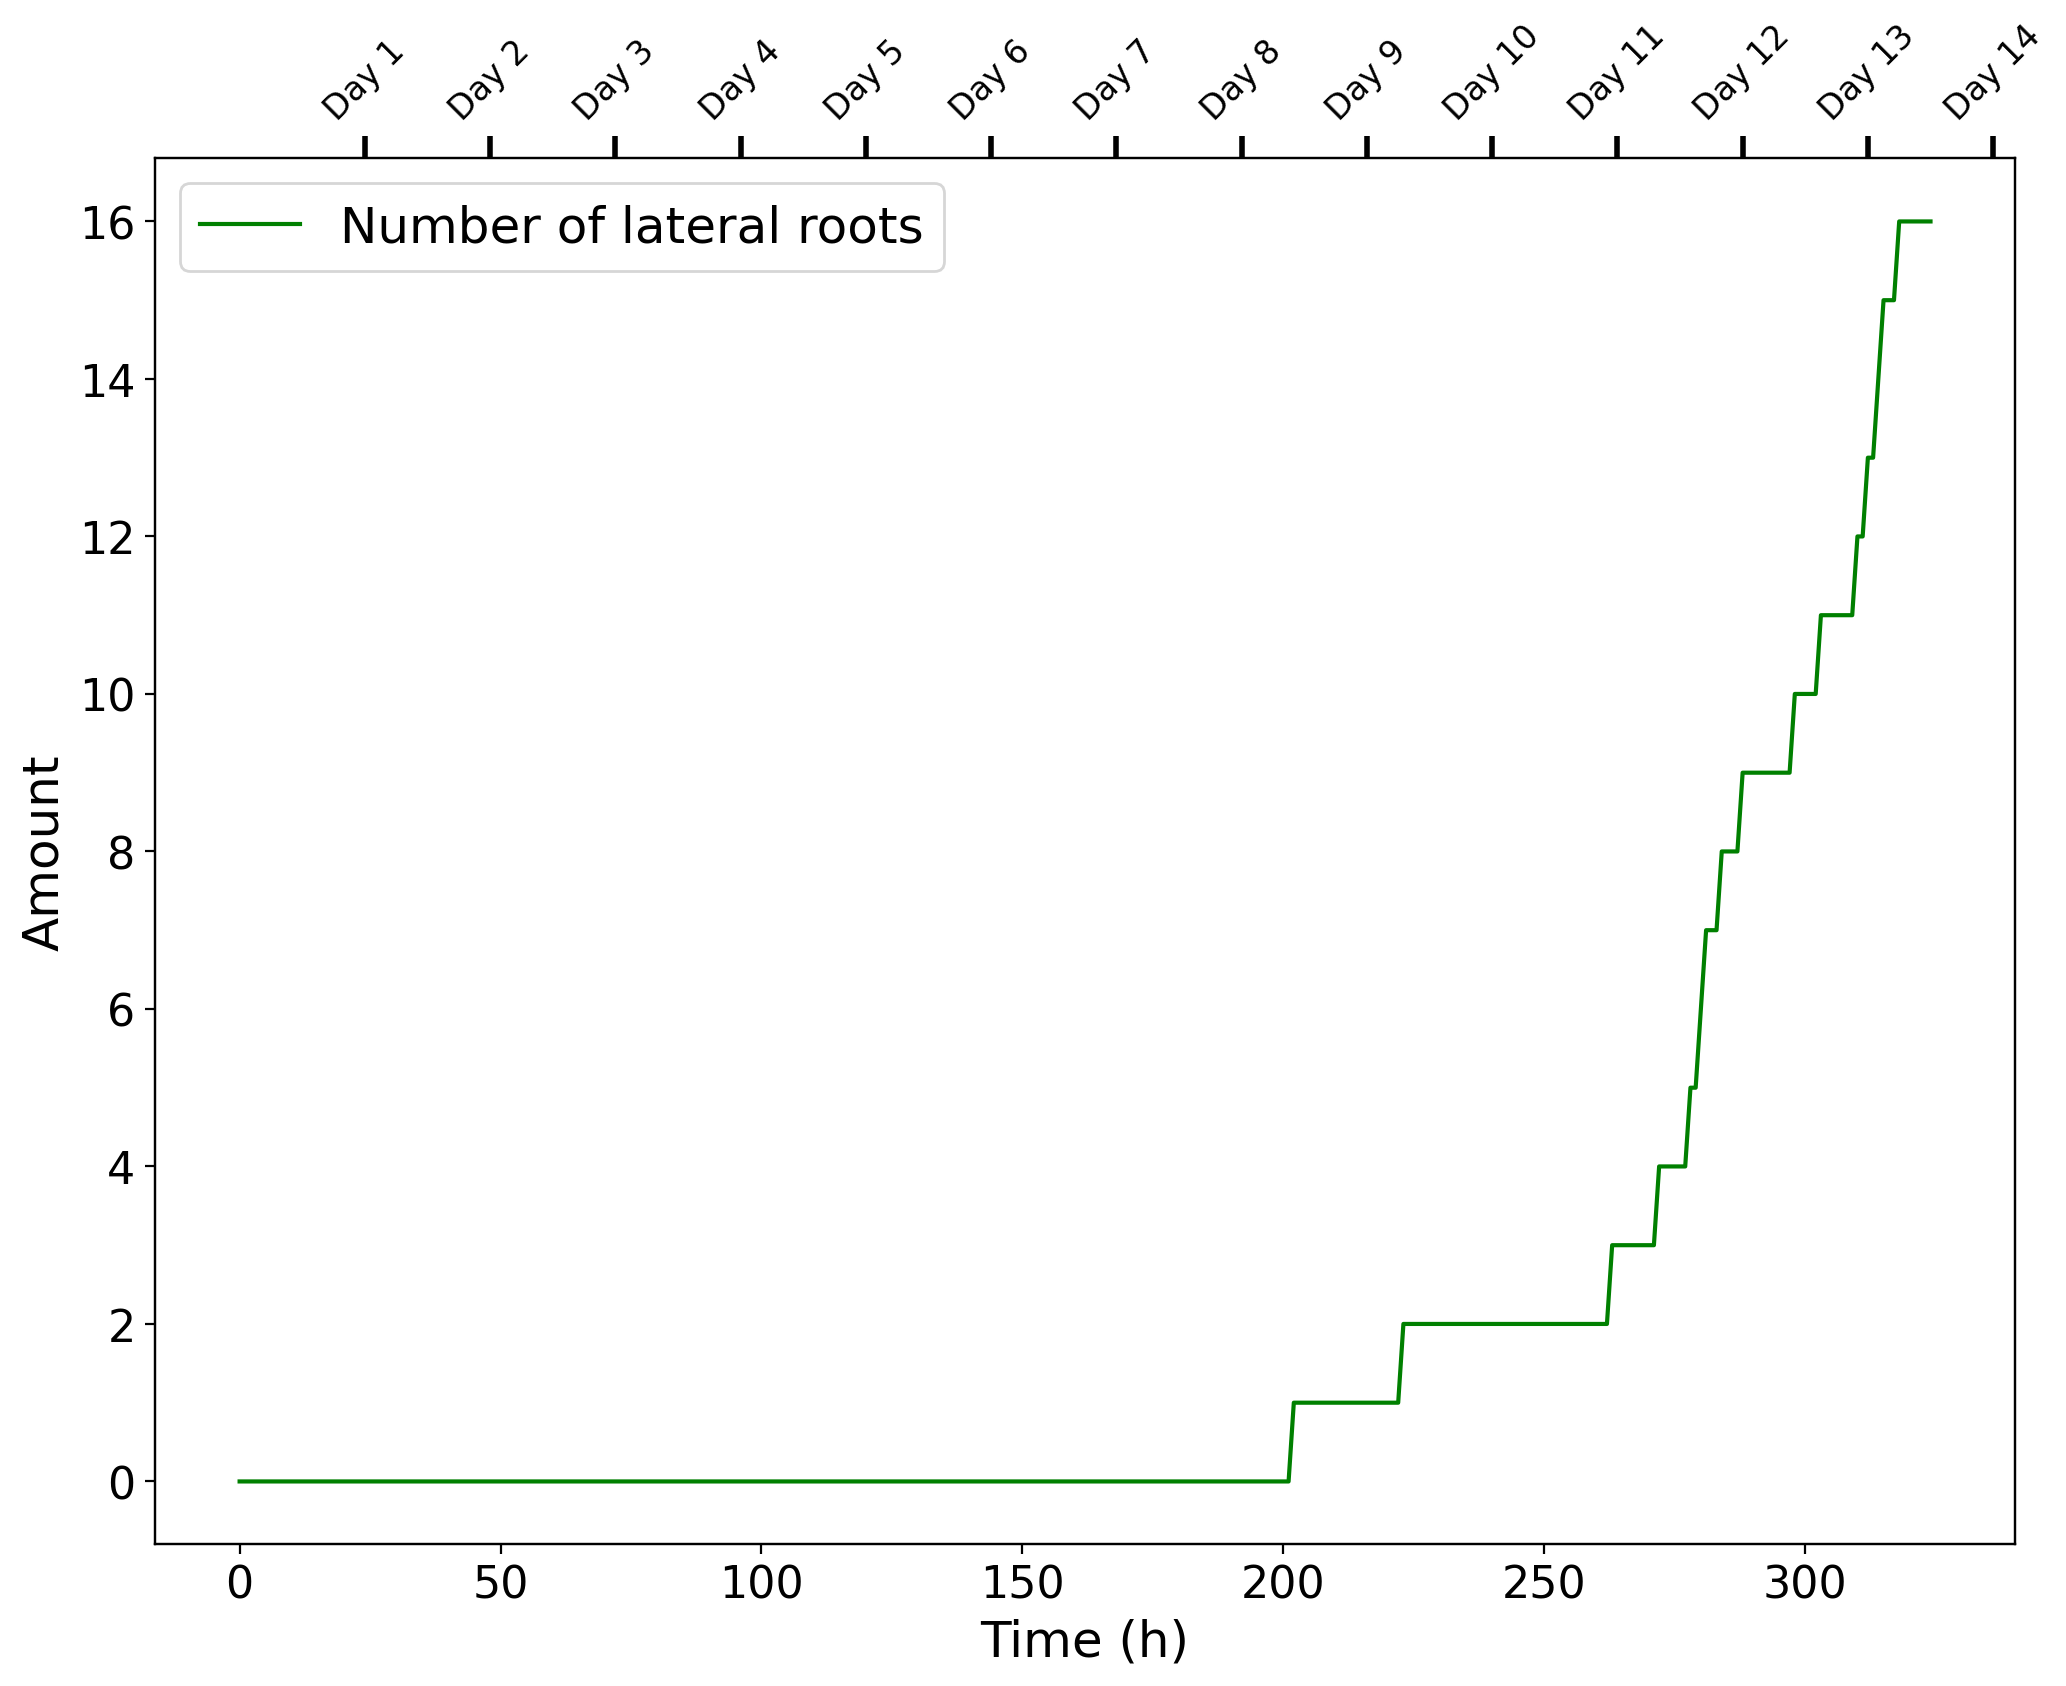

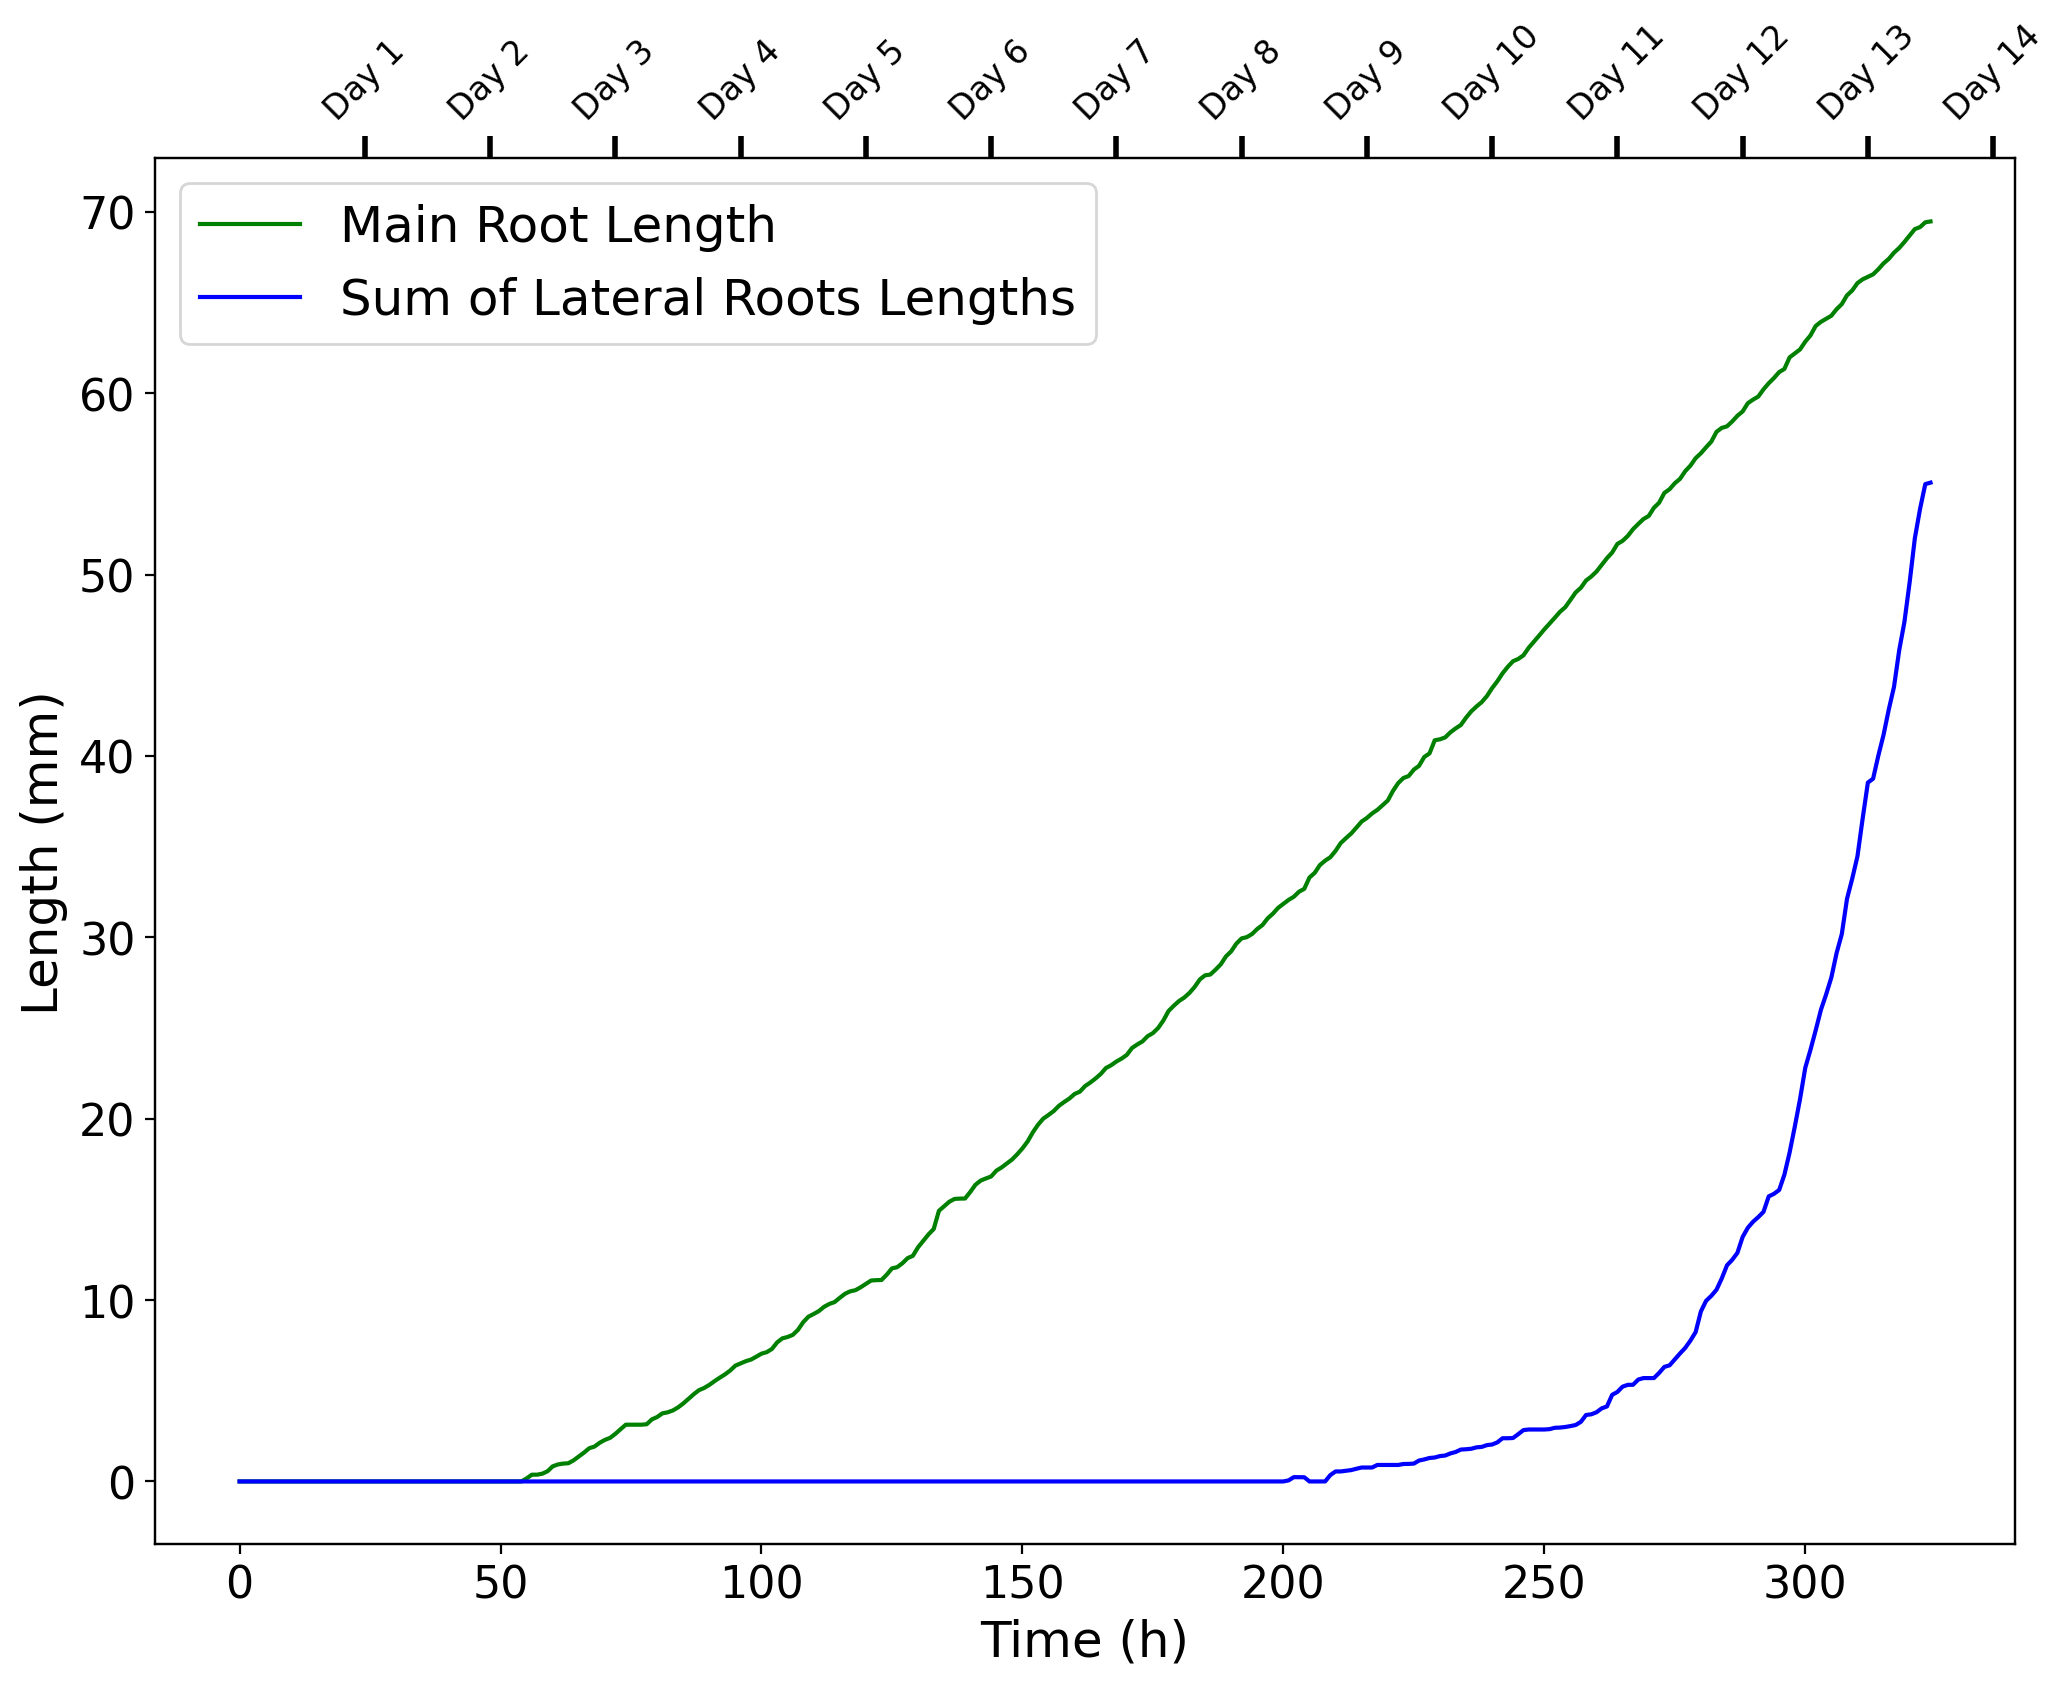

In [41]:
fig, ax = plt.subplots(figsize = (12, 9), dpi = 200)
plot_individual_plant_lr(ax, df)
ax.set_title("")

plt.savefig("example/test3.png", bbox_inches = "tight", dpi = 200)

fig, ax = plt.subplots(figsize = (12, 9), dpi = 200)
plot_individual_plant(ax, df)
ax.set_title("")

plt.savefig("example/test2.png", bbox_inches = "tight", dpi = 200)
plt.show()